In [68]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from util import get_labels, read_img

### Loading labels to inspect classes

In [66]:
labels = get_labels()
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


`labels` is a pandas dataframe with two columns: `id` and `breed`. `id` is the unique identifier for an image (the images in the data folder are named as `<id>.jpg`), and `breed` is the corresponding label.

Let's look at the class distribution:

In [64]:
labels['breed'].value_counts()

scottish_deerhound                126
maltese_dog                       117
afghan_hound                      116
entlebucher                       115
bernese_mountain_dog              114
shih-tzu                          112
pomeranian                        111
great_pyrenees                    111
basenji                           110
samoyed                           109
tibetan_terrier                   107
airedale                          107
leonberg                          106
cairn                             106
japanese_spaniel                  105
beagle                            105
blenheim_spaniel                  102
australian_terrier                102
miniature_pinscher                102
irish_wolfhound                   101
lakeland_terrier                   99
saluki                             99
papillon                           96
siberian_husky                     95
norwegian_elkhound                 95
whippet                            95
pug         

So we have 120 different breeds, with the most common breed being the _scottish dearhound_ and the least common breed the _eskimo dog_ (I have not even heard of that one ever...).

### Let's look at some doggos

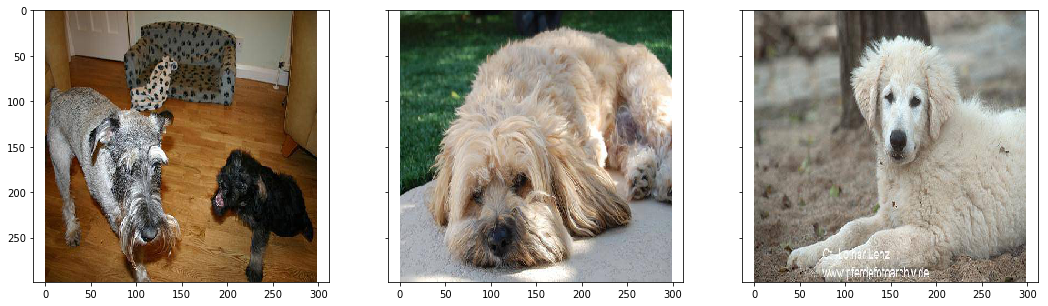

In [81]:
random_doggos = np.random.choice(labels['id'], 3)
imgs = [read_img(doggo, 'train', 299) for doggo in random_doggos]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[18,5], sharey=True)
ax1.imshow(imgs[0]/255)
ax2.imshow(imgs[1]/255)
ax3.imshow(imgs[2]/255)

# FUCKIN' SWEET